# **Data Processing and Impact on UNET Performance**
---
By Stephanie Harmon, PhD (Artificial Intelligence Resource, National Cancer Institute, stephanie dot harmon at nih dot gov)

Based on code by Samira Masoudi, PhD (NCI) from Masoudi, Harmon, et al "Quick Guide on radiology image pre-proessing for deep learning applications in prostate cancer research" J Med Imaging 2021

July 2023

---
This Jupyter notebook tutorial demonstrates how to convert DICOM data downloaded from MIDRC data commons in the previous tutorial, apply image pre-processing steps, and apply a UNET-based lumbar spine segmentation algorithm trained from publicly available data (https://pubmed.ncbi.nlm.nih.gov/35322028/). It was developed to facilitate the Data Science MRI bootcamp held at the 2023 Annual Meeting of the American Association of Physicists in Medicine.

In [2]:
# change these directory paths to reflect your local working directory
import os
home_dir = "/home/mip" 
demo_dir = "{}/Documents/MRIbootcamp".format(home_dir)

os.chdir(demo_dir)

In [3]:
# Please download or clone the following repository, you may choose to do this via terminal
os.system('git clone https://github.com/NIH-MIP/Radiology_Image_Preprocessing_for_Deep_Learning.git')

Cloning into 'Radiology_Image_Preprocessing_for_Deep_Learning'...


0

In [4]:
!pip install pydicom
!pip install simpleitk
!pip install scipy
!pip install scikit-image
!pip install 'monai[all]'

In [5]:
os.chdir('/home/mip/PycharmProjects/aapm/Radiology_Image_Preprocessing_for_Deep_Learning/Codes/')
from __future__ import print_function
import argparse
import sys
import json
import glob
import random
from dicom.Dicom_Tools import *
from utils.utils import *
import csv
from image.Nyul_preprocessing import *
import pandas as pd

# **parse DICOM data and convert to nifti format**

In [6]:
# first we will parse through the images downloaded from MIDRC and convert relevant series to nifti format
os.chdir(demo_dir)
datadir = demo_dir+'/images'
procdir = demo_dir+'/processed'
if not os.path.exists(procdir):
    os.mkdir(procdir)
    os.mkdir(os.path.join(procdir,'raw'))
    os.mkdir(os.path.join(procdir,'bias-corr'))
    os.mkdir(os.path.join(procdir,'ref-normalized'))

#begin by querying all image sets and locating T1 SAG series
# we take advantage of the MIDRC data structure and step through directories
reader = sitk.ImageSeriesReader()
freader = sitk.ImageFileReader()
sitk.ProcessObject_SetGlobalWarningDisplay(False)
t1_processed = []
for pt in os.listdir(datadir):
    print('querying ', pt)
    for study in os.listdir(os.path.join(datadir,pt)):
        # check if series in subdir
        serieslist = reader.GetGDCMSeriesIDs(os.path.join(datadir,pt,study))
        if(len(serieslist)<1):
            # MIDRC stores by study, then series
            for sub in os.listdir(os.path.join(datadir,pt,study)):
                serieslist = reader.GetGDCMSeriesIDs(os.path.join(datadir,pt,study,sub))
                for series in serieslist:
                    dicom_names = reader.GetGDCMSeriesFileNames(os.path.join(datadir,pt,study,series))
                    freader.SetFileName(dicom_names[0])
                    freader.ReadImageInformation()
                    series_name = freader.GetMetaData('0008|103e')
                    # parse DICOM header information for t1 sag acquisitions based on series name
                    if 't1' in series_name.casefold() and 'sag' in series_name.casefold():
                        print('','','found',series_name)
                        series_name = str.replace(freader.GetMetaData('0008|103e'),' ','-')
                        study_date = freader.GetMetaData('0008|0020')
                        series_num = str.replace(freader.GetMetaData('0020|0011'),' ','')
                        ptid = str.replace(freader.GetMetaData('0010|0020'),' ','')
                        if not os.path.exists(os.path.join(procdir,'raw',ptid+'_'+study_date)):
                            os.mkdir(os.path.join(procdir,'raw',ptid+'_'+study_date))
                        reader.SetFileNames(dicom_names)
                        image = reader.Execute()
                        sitk.WriteImage(image,os.path.join(procdir,'raw',ptid+'_'+study_date,ptid+'_'+study_date+'_'+series_num+'_'+series_name+'.nii.gz'))
                        t1_processed.append([os.path.join(datadir,pt,study,series),os.path.join(procdir,'raw',ptid+'_'+study_date,ptid+'_'+study_date+'_'+series_num+'_'+series_name+'.nii.gz')])
sitk.ProcessObject_SetGlobalWarningDisplay(True)    

#save a copy of all converted filepaths
df = pd.DataFrame(t1_processed)
df.to_csv(os.path.join('processed_series.csv'))

querying  10000364-1503940
  found Sag T1
querying  10000364-1436212
  found Sag T1 FSE
querying  10000364-6521243
  found Sag T1
  found Sag T1
querying  10000364-2414476
  found Sag T1
querying  10000364-1437263
  found Sag T1 FSE
querying  10000364-950007
  found SAG T1 WARP VAT 
querying  10000364-1662429
  found Sag T1
querying  10000364-2008660
  found SAG T1
querying  10000364-1406677
  found Sag T1 FSE
querying  10000364-784361
  found SAG T1 WARP VAT 
querying  10000364-1119749
  found Sag T1 FSE
querying  10000364-2397900
  found SAG T1
querying  10000364-2606429
  found SAG T1
querying  10000364-840782
  found Sag T1 FSE
querying  10000364-2022035
  found SAG T1
querying  10000364-5314069
  found Sag T1 FSE
querying  10000364-143380
  found SAG T1
querying  10000364-1116590
  found Sag T1
querying  10000364-5461045
  found Sag T1
querying  10000364-5644815
  found Sag T1 FSE
querying  10000364-1786441
  found SAG T1
querying  10000364-1058096
  found Sag T1 FSE


# **Apply image processing procedures**
<br>In this setting, we have an existing algorithm which has been trained to segment lumbar vertebrae on T1 SAG images. Further details of the training population can be found here: https://pubmed.ncbi.nlm.nih.gov/35322028/.  Prior to training, images underwent N4 Bias correction. Training images were utilized to develop mean landmarks for Nyul normalization of all training and validation images. We will apply the same transformations for our data

## first we apply N4 bias correction

In [7]:
# N4 Bias Correction takes the longest so we will run this first
for series in t1_processed:
    print('processing', series[1])
    img = sitk.ReadImage(series[1])
    image_B = Dicom_Bias_Correct(img)
    if not os.path.exists(os.path.dirname(str.replace(series[1],'raw','bias-corr'))):
        os.mkdir(os.path.dirname(str.replace(series[1],'raw','bias-corr')))
    sitk.WriteImage(image_B,str.replace(series[1],'raw','bias-corr'))

processing /home/mip/Documents/MRIbootcamp/processed/raw/10000364-1503940_19600118/10000364-1503940_19600118_5_Sag-T1.nii.gz
processing /home/mip/Documents/MRIbootcamp/processed/raw/10000364-1436212_19600101/10000364-1436212_19600101_5_Sag-T1-FSE.nii.gz
processing /home/mip/Documents/MRIbootcamp/processed/raw/10000364-6521243_19591003/10000364-6521243_19591003_9_Sag-T1.nii.gz
processing /home/mip/Documents/MRIbootcamp/processed/raw/10000364-6521243_19591003/10000364-6521243_19591003_5_Sag-T1.nii.gz
processing /home/mip/Documents/MRIbootcamp/processed/raw/10000364-2414476_19600419/10000364-2414476_19600419_5_Sag-T1.nii.gz
processing /home/mip/Documents/MRIbootcamp/processed/raw/10000364-1437263_19600101/10000364-1437263_19600101_4_Sag-T1-FSE.nii.gz
processing /home/mip/Documents/MRIbootcamp/processed/raw/10000364-950007_19600430/10000364-950007_19600430_3_SAG-T1-WARP-VAT-.nii.gz
processing /home/mip/Documents/MRIbootcamp/processed/raw/10000364-1662429_19600101/10000364-1662429_19600101_

## now we apply Nyul normalization using landmarks identified in training dataset
landmarks are available for download here: https://drive.google.com/file/d/1RPrB_xnevhruKfXpXf1L3KOyUzUk3gPj/view?usp=sharing 
<br> please place them in your demo directory

In [8]:
# load Nyul landmarks from training dataset
Model_Path = join(demo_dir,'images.npz')
f = np.load(Model_Path, allow_pickle=True)
Model = f['trainedModel'].all()
meanLandmarks = Model['meanLandmarks']

for series in t1_processed:
    print('processing', str.replace(series[1],'raw','bias-corr'))
    img = sitk.ReadImage(str.replace(series[1],'raw','bias-corr'))
    image_B_N = transform(img,meanLandmarks=meanLandmarks)
    if not os.path.exists(os.path.dirname(str.replace(series[1],'raw','ref-normalized'))):
        os.mkdir(os.path.dirname(str.replace(series[1],'raw','ref-normalized')))
    sitk.WriteImage(image_B_N,str.replace(series[1],'raw','ref-normalized'))

processing /home/mip/Documents/MRIbootcamp/processed/bias-corr/10000364-1503940_19600118/10000364-1503940_19600118_5_Sag-T1.nii.gz
processing /home/mip/Documents/MRIbootcamp/processed/bias-corr/10000364-1436212_19600101/10000364-1436212_19600101_5_Sag-T1-FSE.nii.gz
processing /home/mip/Documents/MRIbootcamp/processed/bias-corr/10000364-6521243_19591003/10000364-6521243_19591003_9_Sag-T1.nii.gz
processing /home/mip/Documents/MRIbootcamp/processed/bias-corr/10000364-6521243_19591003/10000364-6521243_19591003_5_Sag-T1.nii.gz
processing /home/mip/Documents/MRIbootcamp/processed/bias-corr/10000364-2414476_19600419/10000364-2414476_19600419_5_Sag-T1.nii.gz
processing /home/mip/Documents/MRIbootcamp/processed/bias-corr/10000364-1437263_19600101/10000364-1437263_19600101_4_Sag-T1-FSE.nii.gz
processing /home/mip/Documents/MRIbootcamp/processed/bias-corr/10000364-950007_19600430/10000364-950007_19600430_3_SAG-T1-WARP-VAT-.nii.gz
processing /home/mip/Documents/MRIbootcamp/processed/bias-corr/1000

# **apply UNET segmentation algorithm**
UNET model was trained in MONAI framework
<br>model weights are available for download here: https://drive.google.com/file/d/16OdOc1uXn8A2JJP2o6uFi5TlkAoNNd_c/view?usp=sharing
<br> please place them in your demo directory under "models/UNET_lumbar_v2_norm.pth"

In [9]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from monai.handlers.utils import from_engine
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandScaleIntensityd,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
    RandCropByLabelClassesd,
    EnsureTyped,
    NormalizeIntensityd,
    SpatialPadd
)
from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    ImageWriter
)
import scipy.ndimage as ndimage
import nibabel as nib
import torch
import glob

In [10]:
def resample_3d(img, target_size):
    imx, imy, imz = img.shape
    tx, ty, tz = target_size
    zoom_ratio = (float(tx) / float(imx), float(ty) / float(imy), float(tz) / float(imz))
    img_resampled = ndimage.zoom(img, zoom_ratio, order=0, prefilter=False)
    return img_resampled

In [11]:
# Define UNET and load pre-trained model dictionary
model_path = demo_dir+'/models/UNET_lumbar_v2_norm.pth' #set model name
device = torch.device("cuda:0") #set which GPU to use
print("using cuda:0")

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

tensor_dict = torch.load(model_path, map_location=device)
model.load_state_dict(tensor_dict)

using cuda:0


<All keys matched successfully>

In [12]:
# define our testing data and transformations
# please note the test_transformations should match validation procedure in training
outdir = demo_dir+'/output'
if not os.path.exists(outdir):
    os.mkdir(outdir)
    os.mkdir(os.path.join(outdir,'raw'))
    os.mkdir(os.path.join(outdir,'bias-corr'))
    os.mkdir(os.path.join(outdir,'ref-normalized'))
    
test_images = sorted(glob.glob(procdir+'/**/**/*.nii.gz'))
test_dicts = [{'image': image_name}for image_name in zip(test_images)]

test_transforms = [
    LoadImaged(keys=['image']),
    AddChanneld(keys=['image']),
    Orientationd(keys=["image"], axcodes="RAS"),
    Spacingd(keys=['image'],pixdim=(3.0,0.5,0.5),mode="bilinear"),
    NormalizeIntensityd(keys=["image"], nonzero=True),  # intensity
    SpatialPadd(keys=["image"],spatial_size=[16, 224, 224]),
    ToTensord(keys=['image']),
    EnsureTyped(keys=["image"]),
]

test_transforms = Compose(test_transforms)
# create a validation data loader
check_test = CacheDataset(data=test_dicts, transform=test_transforms, num_workers=1,cache_rate=0.5)
test_loader = DataLoader(check_test, batch_size=1, num_workers=1)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
<class 'monai.transforms.utility.dictionary.AddChanneld'>: Class `AddChanneld` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transforms.EnsureChannelFirstd instead with `channel_dim='no_channel'`.
monai.transforms.utility.dictionary EnsureChannelFirstd.__init__:meta_keys: Argument `meta_keys` has been deprecated since version 0.9. not needed if image is type `MetaTensor`.
Loading dataset: 100%|██████████████████████████████████████████████████████████████| 34/34 [00:19<00:00,  1.73it/s]


In [14]:
# run through sliding window inference
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        val_inputs = batch["image"].cuda()
        original_affine = batch["image_meta_dict"]["affine"][0].numpy()
        # print(val_inputs.cpu().numpy().shape)
        _, _, h, w, d = val_inputs.cpu().numpy().shape
        target_shape = (h, w, d)
        img_name = batch["image_meta_dict"]["filename_or_obj"][0].split("/")[-1]
        print("Inference on case {}".format(img_name))
        roi_size = [16, 224, 224]
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model, overlap=0.6, mode="gaussian")
        val_outputs = torch.softmax(val_outputs, 1).cpu().numpy()
        val_outputs = np.argmax(val_outputs, axis=1).astype(np.uint8)[0]
        val_inputs = val_inputs.cpu().numpy()[0, 0, :, :, :]
        val_outputs = resample_3d(val_outputs, target_shape)
        # we swap output axes due to saggital acquisition
        val_outputs = np.swapaxes(val_outputs,0,2)
        val_outputs = np.swapaxes(val_outputs, 0, 1)
        val_outputs = np.flip(val_outputs, 0)
        val_inputs = np.swapaxes(val_inputs,0,2)
        val_inputs = np.swapaxes(val_inputs, 0, 1)
        val_inputs = np.flip(val_inputs, 0)
        if 'raw' in batch["image_meta_dict"]["filename_or_obj"][0]:
            nib.save(nib.Nifti1Image(val_outputs.astype(np.uint8), original_affine), os.path.join(outdir,'raw', str.replace(img_name,'.nii.gz','_seg.nii.gz')))
            nib.save(nib.Nifti1Image(val_inputs, original_affine),os.path.join(outdir,'raw', img_name))
        elif 'bias' in batch["image_meta_dict"]["filename_or_obj"][0]:
            nib.save(nib.Nifti1Image(val_outputs.astype(np.uint8), original_affine), os.path.join(outdir,'bias-corr', str.replace(img_name,'.nii.gz','_seg.nii.gz')))
            nib.save(nib.Nifti1Image(val_inputs, original_affine),os.path.join(outdir,'bias-corr', img_name))
        elif 'ref-normalized' in batch["image_meta_dict"]["filename_or_obj"][0]:
            nib.save(nib.Nifti1Image(val_outputs.astype(np.uint8), original_affine), os.path.join(outdir,'ref-normalized', str.replace(img_name,'.nii.gz','_seg.nii.gz')))
            nib.save(nib.Nifti1Image(val_inputs, original_affine),os.path.join(outdir,'ref-normalized', img_name))

Inference on case 10000364-1058096_19600114_4_Sag-T1-FSE.nii.gz
Inference on case 10000364-1116590_19600129_5_Sag-T1.nii.gz
Inference on case 10000364-1119749_19600103_6_Sag-T1-FSE.nii.gz
Inference on case 10000364-1406677_19591129_4_Sag-T1-FSE.nii.gz
Inference on case 10000364-143380_19600108_4_SAG-T1.nii.gz
Inference on case 10000364-1436212_19600101_5_Sag-T1-FSE.nii.gz
Inference on case 10000364-1437263_19600101_4_Sag-T1-FSE.nii.gz
Inference on case 10000364-1503940_19600118_5_Sag-T1.nii.gz
Inference on case 10000364-1662429_19600101_5_Sag-T1.nii.gz
Inference on case 10000364-1786441_19590329_4_SAG-T1.nii.gz
Inference on case 10000364-2008660_19600603_4_SAG-T1.nii.gz
Inference on case 10000364-2022035_19600101_4_SAG-T1.nii.gz
Inference on case 10000364-2397900_19590807_4_SAG-T1.nii.gz
Inference on case 10000364-2414476_19600419_5_Sag-T1.nii.gz
Inference on case 10000364-2606429_19590418_4_SAG-T1.nii.gz
Inference on case 10000364-5314069_19600103_3_Sag-T1-FSE.nii.gz
Inference on case

## now lets check an example and see how normalization impacts performance

Loading dataset: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


Inference on case /home/mip/Documents/MRIbootcamp/processed/bias-corr/10000364-1786441_19590329/10000364-1786441_19590329_4_SAG-T1.nii.gz
(560, 560, 24)


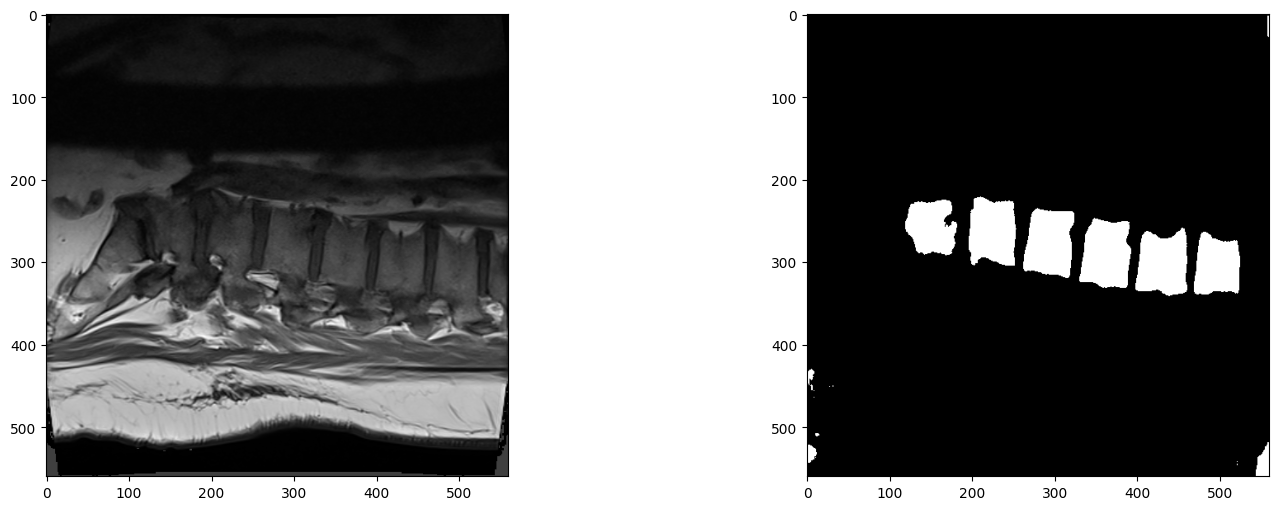

Inference on case /home/mip/Documents/MRIbootcamp/processed/raw/10000364-1786441_19590329/10000364-1786441_19590329_4_SAG-T1.nii.gz
(560, 560, 24)


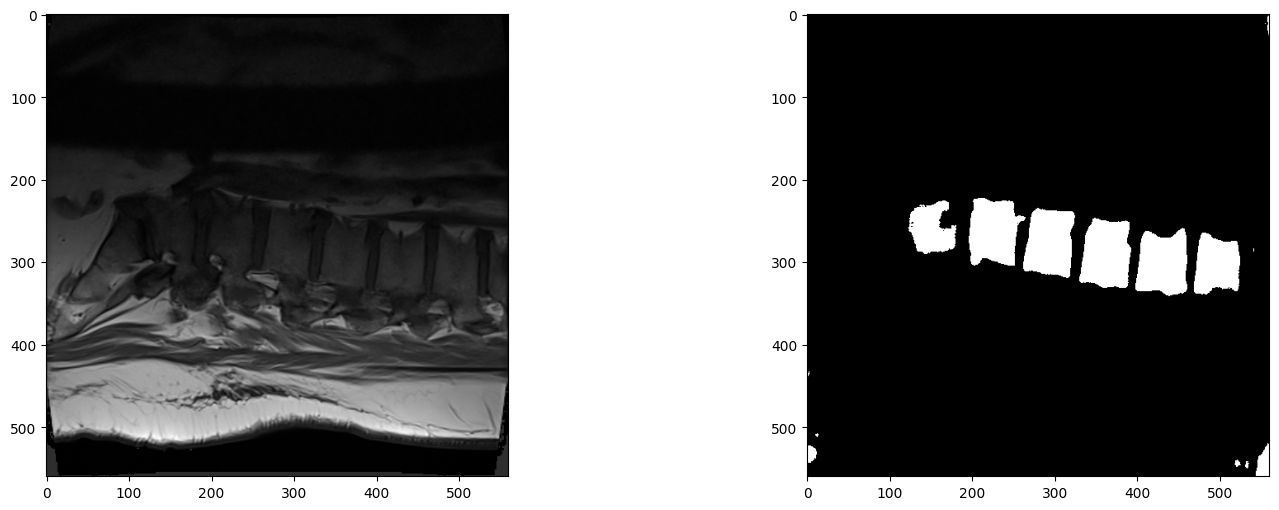

Inference on case /home/mip/Documents/MRIbootcamp/processed/ref-normalized/10000364-1786441_19590329/10000364-1786441_19590329_4_SAG-T1.nii.gz
(560, 560, 24)


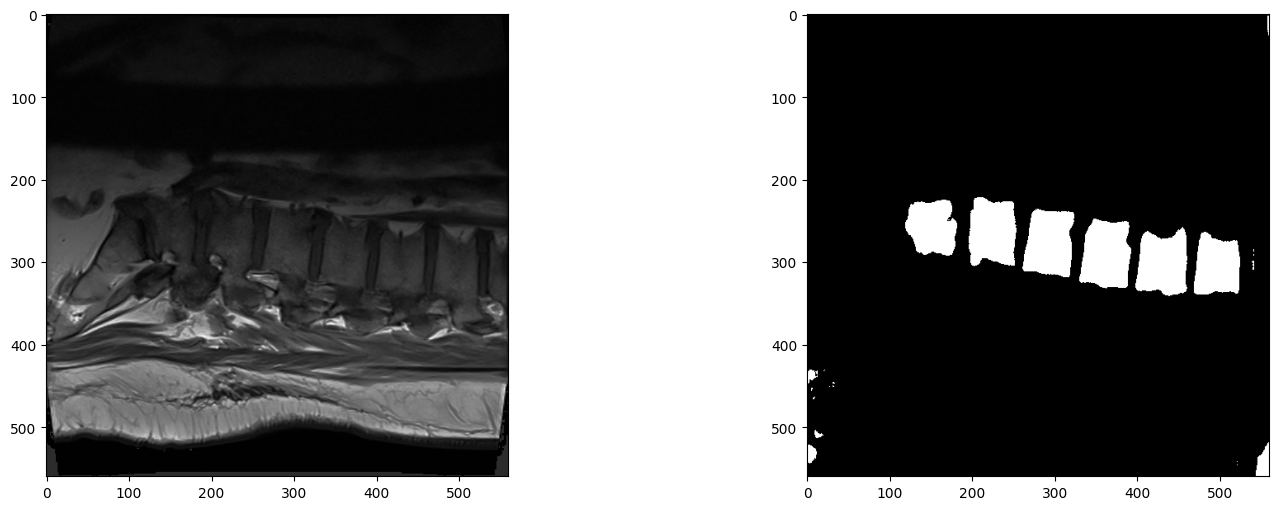

In [30]:
test_images = sorted(glob.glob(procdir+'/**/**/10000364-1786441_19590329_4_SAG-T1.nii.gz'))
test_dicts = [{'image': image_name}for image_name in zip(test_images)]

test_transforms = [
    LoadImaged(keys=['image']),
    AddChanneld(keys=['image']),
    Orientationd(keys=["image"], axcodes="RAS"),
    Spacingd(keys=['image'],pixdim=(3.0,0.5,0.5),mode="bilinear"),
    NormalizeIntensityd(keys=["image"], nonzero=True),  # intensity
    SpatialPadd(keys=["image"],spatial_size=[16, 224, 224]),
    ToTensord(keys=['image']),
    EnsureTyped(keys=["image"]),
]

test_transforms = Compose(test_transforms)
# create a validation data loader
check_test = CacheDataset(data=test_dicts, transform=test_transforms, num_workers=1,cache_rate=0.5)
test_loader = DataLoader(check_test, batch_size=1, num_workers=1)

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        val_inputs = batch["image"].cuda()
        original_affine = batch["image_meta_dict"]["affine"][0].numpy()
        # print(val_inputs.cpu().numpy().shape)
        _, _, h, w, d = val_inputs.cpu().numpy().shape
        target_shape = (h, w, d)
        img_name = batch["image_meta_dict"]["filename_or_obj"][0].split("/")[-1]
        print("Inference on case {}".format(batch["image_meta_dict"]["filename_or_obj"][0]))
        roi_size = [16, 224, 224]
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model, overlap=0.6, mode="gaussian")
        val_outputs = torch.softmax(val_outputs, 1).cpu().numpy()
        val_outputs = np.argmax(val_outputs, axis=1).astype(np.uint8)[0]
        val_inputs = val_inputs.cpu().numpy()[0, 0, :, :, :]
        val_outputs = resample_3d(val_outputs, target_shape)
        val_outputs = np.swapaxes(val_outputs,0,2)
        val_outputs = np.swapaxes(val_outputs, 0, 1)
        val_outputs = np.flip(val_outputs, 0)
        val_inputs = np.swapaxes(val_inputs,0,2)
        val_inputs = np.swapaxes(val_inputs, 0, 1)
        val_inputs = np.flip(val_inputs, 0)

        print(val_inputs.shape)
        plt.figure("check",(18,6))
        plt.subplot(1,2,1)
        plt.imshow(val_inputs[:,:,17],cmap="gray")
        plt.subplot(1,2,2)
        plt.imshow(val_outputs[:,:,17],cmap="gray")
        plt.show()

# Model Training 
for reproducibility, model training data utilized in this example is provided here by request: https://drive.google.com/file/d/1I6OdJ51a1P77mxtqyweqSyA-Ml4moUxO/view?usp=sharing